In [1]:
import os
import pandas as pd
import numpy as np
import mca

In [2]:
os.listdir('.')

['.ipynb_checkpoints',
 'migrated',
 'Base models-entire data.ipynb',
 'Basic models.ipynb',
 'EDA_Challenge.ipynb',
 'EDA.ipynb',
 'EDA_trainData.ipynb',
 'Ensemble models.ipynb',
 'xgboost with null.ipynb',
 'Untitled.ipynb',
 'Base models-clean.ipynb',
 'nohup.out',
 'jupyter_notebook_config.py',
 'LR_100iter_impute_full.csv',
 'SGD_1000iter_impute_full.csv',
 'RFC_depth4_impute-full.csv',
 'XGB-entiretrainscl-impute-full.csv',
 'data_clean.ipynb',
 'PCA.ipynb',
 'RFC_depth4_impute-full_pca.csv',
 'XGB-entiretrainscl-impute-pca.csv']

In [20]:
import time
t1=time.time()
train = pd.read_table('/aichallenge/challengeData.tsv')
test = pd.read_table('/aichallenge/scoring_set.tsv')
t2=time.time()
print(t2-t1)

/usr/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (6,16,17,26,40,41,49,53,97,98,99,100,104,107,109,112,127,128,129,130,220,221,222) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (6,16,17,26,40,41,49,53,54,55,100,104,107,109,112,127,128,129,130,153,171,220,221,222,225,226,227) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


138.88337469100952


In [21]:
train.columns

Index(['challenge_data.innovation_challenge_key',
       'challenge_data.renewed_yorn', 'challenge_data.instance_id',
       'challenge_data.contract_line_id', 'challenge_data.minor_line_yorn',
       'challenge_data.major_line_instance_id',
       'challenge_data.installation_date',
       'challenge_data.product_sales_order_type',
       'challenge_data.product_purchase_order_type',
       'challenge_data.instance_status',
       ...
       'challenge_data.service_distributor_base_theater_name',
       'challenge_data.service_distributor_base_distributor_normalized_name',
       'challenge_data.contract_line_net_usd_amount',
       'challenge_data.product_net_price',
       'challenge_data.sales_node_renewal_rate',
       'challenge_data.customer_renewal_rate',
       'challenge_data.partner_renewal_rate',
       'challenge_data.product_renewal_rate',
       'challenge_data.service_sales_node_installed_base_sales_node_renewal_rate',
       'challenge_data.service_partner_installed_ba

In [22]:
#remove data set name from columns names to make it uniform
t1=time.time()
columns=[]
for col in train.columns:
    columns.append(col.replace('challenge_data.',''))
train.columns=columns
columns=[]
for col in test.columns:
    columns.append(col.replace('scoring_set.',''))
test.columns=columns
t2=time.time()
print(t2-t1)

0.0014498233795166016


In [27]:
#remove the rows where 'challenge_data.renewed_yorn' is null in training data
t1=time.time()
train=train[train['renewed_yorn'].notnull()]
t2=time.time()
print(t2-t1)

KeyError: 'renewed_yorn'

In [24]:
#remove the 'challenge_data.renewed_yorn' from training and test data and move it to a seperate variable
t1=time.time()
train_y=train['renewed_yorn']
train = train.drop('renewed_yorn',axis=1)
test_y=test['renewed_yorn']
test = test.drop('renewed_yorn',axis=1)
t2=time.time()
print(t2-t1)

4.139721155166626


In [25]:
#remove columns which have more than 0.5 null values
t1=time.time()
percent = (train.isnull().sum()/train.isnull().count())
train.columns[percent>0.5]
#We would ignore all these 102 columns so we are left with 135 columns
len(train.columns[percent>0.5])
#all_clean_columns=train.columns[percent==0]
#train_clean=train[all_clean_columns]
unclean_columns=test.columns[percent>0.5]
train = train.drop(unclean_columns,axis=1)
test = test.drop(unclean_columns,axis=1)
t2=time.time()
print(t2-t1)

9.64650297164917


In [26]:
train['major_line_instance_id'].unique()

array(['0A1639173E7ABD9BDD35A5EC980B932E01C293939210F0737535E10CC29E0284',
       '0486A25069AB01F95CF4B85CCC64408767C6A53DF7B2510355DC82C3A106B7ED',
       '07B384DCEB1B7692CAFD38806AA4542A6973ACD893755C7BF4A6067810B1C0D6',
       ...,
       '019F3BE24B57ED3484ACE4528C5D7AC184563CF65C4E9B9EFD869CE2CA52C752',
       '0363A480FE0DD214C76D6E3479571E5B6D2FF1861C85466F336A47B629AD4F11',
       '020167519BA6B73171807389FF543BD70E5C311691DC8101DF147A20DA401725'],
      dtype=object)

In [77]:
#Remove columns which have too many categories and is string type
t1=time.time()
messy_columns = []
for col in test.columns:
    if(test[col].dtype=='object' and len(test[col].unique())>100):
        messy_columns.append(col)
t2=time.time()
print(t2-t1)

21.49243140220642


In [78]:
# 78 messy columns are removed
len(messy_columns)

75

In [79]:
t1=time.time()
train=train.drop(messy_columns,axis=1)
test=test.drop(messy_columns,axis=1)
t2=time.time()
print(t2-t1)

2.891085147857666


In [80]:
train.shape

(226140, 120)

In [81]:
#Remove the primary key column for data fitting
t1=time.time()
train_ids=train['innovation_challenge_key']
test_ids=test['innovation_challenge_key']
train = train.drop('innovation_challenge_key',axis=1)
test = test.drop('innovation_challenge_key',axis=1)
t2=time.time()
print(t2-t1)

2.114413261413574


In [82]:
#Number of unique values in each columns
t1=time.time()
catcols=[]
scalcols=[]
for col in train.columns:
    if (train[col].dtype !='object'):
        if(len(train[col].unique())<20):
            catcols.append(col)
        else:
            scalcols.append(col)
t2=time.time()
print(t2-t1)

0.023067474365234375


In [83]:
#handle catcols
t1=time.time()
for col in catcols:
    train[col]=train[col].astype('category')
    test[col]=test[col].astype('category')
t2=time.time()
print(t2-t1)

0.1856088638305664


In [84]:
#Replace integer nans with mean 
train[scalcols]=train[scalcols].fillna(train[scalcols].mean())
test[scalcols]=test[scalcols].fillna(test[scalcols].mean())

In [85]:
train[scalcols].isnull().any()

contract_line_net_usd_amount    False
product_net_price               False
dtype: bool

In [86]:
test[scalcols].isnull().any()

contract_line_net_usd_amount    False
product_net_price               False
dtype: bool

In [87]:
#Normalize integer data
t1=time.time()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(train[scalcols])
train[scalcols] = scaler.transform(train[scalcols])
scaler = scaler.fit(test[scalcols])
test[scalcols] = scaler.transform(test[scalcols])
t2=time.time()
print(t2-t1)

0.6246292591094971


In [88]:
train[scalcols].describe()

,contract_line_net_usd_amount,product_net_price
count,2.261400e+05,2.261400e+05
mean,1.005455e-17,1.206546e-17
std,1.000002e+00,1.000002e+00
min,-1.252316e-01,-2.321716e-01
25%,-1.252316e-01,-2.321716e-01
50%,-1.252316e-01,-2.321716e-01
75%,-1.252316e-01,-1.584198e-01
max,7.774224e+01,6.648806e+01


In [89]:
train[catcols].describe()

,product_transaction_type,contract_line_reaction_time_code,sales_hierarchy_level,service_sales_node_base_sales_hierarchy_level
count,226140,226140,226140,226140
unique,3,3,6,6
top,10002,-1,6,6
freq,202522,225296,199960,224170


In [90]:
unclean_cols=train.columns[train.isnull().any()]

In [91]:
#replace all other 43 cols nan with mode values
train[unclean_cols]=train[unclean_cols].fillna(train[unclean_cols].median())
test[unclean_cols]=test[unclean_cols].fillna(test[unclean_cols].median())

In [92]:
#convert data to one hot encoding to handle categorical values
t1=time.time()
train_objs_num = len(train)
dataset = pd.concat(objs=[train, test], axis=0)
dataset = pd.get_dummies(dataset)
train = dataset[:train_objs_num]
test = dataset[train_objs_num:]
t2=time.time()
print(t2-t1)

23.214226484298706


In [93]:
train.columns

Index(['contract_line_reaction_time_code',
       'service_sales_node_base_sales_hierarchy_level',
       'contract_line_net_usd_amount', 'product_net_price',
       'minor_line_yorn_N', 'minor_line_yorn_Y',
       'instance_status_Latest-INSTALLED', 'product_transaction_type_-9999',
       'product_transaction_type_10000', 'product_transaction_type_10002',
       ...
       'service_distributor_base_distributor_name_63E656F07CCA14C7E92A9CF75C45C2F0E5BDFD3A07A1EF9EC3E92F5AF051FA22',
       'service_distributor_base_distributor_name_7F3282462F1B81C79FE6937D9B49AF13384D961DDF42DF6CF1BB59D7630308A2',
       'service_distributor_base_distributor_name_815A7B66FE919A14C089996194F98F696B39D83332E31755073B836FEA52C364',
       'service_distributor_base_distributor_name_84DCB9C6A3A305DBE0088EDCF4C4BC00C13208407ADA44DFBECEA93D98E8D4B3',
       'service_distributor_base_distributor_name_861E3825094B361623EE986A723F9B544B21EC4718F3667780CB8528C4E6767C',
       'service_distributor_base_distributor

In [94]:
#print the new columns we got
train.shape

(226140, 444)

In [95]:
test.shape

(1888195, 444)

In [37]:
#Replace all NaN left with 0 No nans left
'''t1=time.time()
train_X = train_X.fillna(0)
test_X = test_X.fillna(0)
t2=time.time()
print(t2-t1)'''

't1=time.time()\ntrain_X = train_X.fillna(0)\ntest_X = test_X.fillna(0)\nt2=time.time()\nprint(t2-t1)'

In [38]:
#check data quality now
train.isnull().any().any()

False

In [39]:
#check data quality now
test.isnull().any().any()

False

In [96]:
import gc
del dataset
gc.collect()

1341

In [97]:
#split the data between train and validation set
t1=time.time()
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train,train_y,test_size=0.33, random_state=42)
t2=time.time()
print(t2-t1)

0.5088908672332764


In [98]:
#Dimensions of training data
X_train.shape

(151513, 444)

In [99]:
#Time to introduce PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
%matplotlib inline

In [100]:
X_train.head()

,contract_line_reaction_time_code,service_sales_node_base_sales_hierarchy_level,contract_line_net_usd_amount,product_net_price,minor_line_yorn_N,minor_line_yorn_Y,instance_status_Latest-INSTALLED,product_transaction_type_-9999,product_transaction_type_10000,product_transaction_type_10002,...,service_distributor_base_distributor_name_63E656F07CCA14C7E92A9CF75C45C2F0E5BDFD3A07A1EF9EC3E92F5AF051FA22,service_distributor_base_distributor_name_7F3282462F1B81C79FE6937D9B49AF13384D961DDF42DF6CF1BB59D7630308A2,service_distributor_base_distributor_name_815A7B66FE919A14C089996194F98F696B39D83332E31755073B836FEA52C364,service_distributor_base_distributor_name_84DCB9C6A3A305DBE0088EDCF4C4BC00C13208407ADA44DFBECEA93D98E8D4B3,service_distributor_base_distributor_name_861E3825094B361623EE986A723F9B544B21EC4718F3667780CB8528C4E6767C,service_distributor_base_distributor_name_98F1585B970DBC564E4063B0DFEFF2BB7A1A6F48B54D457B46379F06A8D2F740,service_distributor_base_distributor_name_D496D3E841D7F257C8B8314A580E5728BC034FD09FD4360908B2103860CC728F,service_distributor_base_distributor_name_E15FFA65FCD7A17CF3F1FE025C496E1B5C5D6A5126918C5FFEFFC411240000F5,service_distributor_base_distributor_name_F833682236B2695F4EF3508100C9FFE86918E501D562BC55B221D346D30E99D9,service_distributor_base_distributor_normalized_name_A096DD969881554D12B5297CD9DF3CB0C6632E882AA28126C8FC410923A74EDF
227682,-1,6,-0.125232,-0.232172,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
120974,-1,6,-0.125232,-0.232172,0,1,1,0,0,1,...,0,0,0,0,0,0,0,1,0,1
48142,-1,6,-0.125232,-0.232172,0,1,1,0,0,1,...,0,0,0,0,0,0,0,1,0,1
36978,-1,6,-0.125232,-0.232172,0,1,1,0,0,1,...,0,0,0,0,0,0,0,1,0,1
124715,-1,6,-0.125232,-0.232172,0,1,1,0,0,1,...,0,0,0,0,0,0,0,1,0,1


In [101]:
X = scale(X_train)

In [102]:
pca = PCA()

In [103]:
t1=time.time()
pca.fit(X)
t2=time.time()
print(t2-t1)

7.1434407234191895


In [104]:
var= pca.explained_variance_ratio_

In [105]:
#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

In [106]:
print(var1)

[  6.09  10.64  13.69  16.37  18.61  20.75  22.78  24.65  26.3   27.85
  29.26  30.64  31.96  33.17  34.31  35.4   36.47  37.53  38.56  39.54
  40.5   41.44  42.37  43.29  44.18  45.07  45.94  46.8   47.65  48.48
  49.29  50.09  50.88  51.63  52.37  53.07  53.75  54.41  55.05  55.67
  56.29  56.89  57.47  58.04  58.59  59.13  59.66  60.18  60.7   61.21
  61.71  62.21  62.7   63.19  63.68  64.17  64.66  65.14  65.62  66.09
  66.55  67.01  67.46  67.91  68.35  68.79  69.21  69.63  70.05  70.45
  70.84  71.23  71.61  71.98  72.35  72.7   73.05  73.39  73.73  74.06
  74.39  74.72  75.04  75.35  75.66  75.96  76.26  76.56  76.86  77.15
  77.44  77.73  78.01  78.29  78.57  78.85  79.12  79.39  79.66  79.93
  80.19  80.45  80.71  80.97  81.23  81.49  81.74  81.99  82.24  82.49
  82.74  82.99  83.24  83.48  83.72  83.96  84.2   84.44  84.68  84.92
  85.16  85.4   85.64  85.88  86.12  86.36  86.6   86.84  87.08  87.31
  87.54  87.77  88.    88.23  88.46  88.69  88.92  89.14  89.36  89.58
  89.8

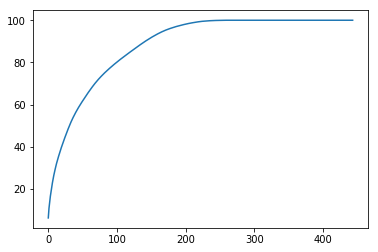

In [107]:
plt.plot(var1)

In [108]:
#so we take 200 components
pca = PCA(n_components=200)

In [109]:
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=200, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [110]:
X_train=pca.fit_transform(X)

In [111]:
X_valid=scale(X_valid)
test=scale(test)
X_valid=pca.fit_transform(X_valid)
test=pca.fit_transform(test)

In [112]:
#Lets start fitting different models on the data
#1. start with simple Bayes model
t1=time.time()
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gaussian_model = gnb.fit(X_train,y_train)
t2=time.time()
print(t2-t1)

0.7353649139404297


In [114]:
type(X_valid)

numpy.ndarray

In [115]:
# Lets see the prediction on our validation data
t1=time.time()
pred = gaussian_model.predict_proba(X_valid)
t2=time.time()
print(t2-t1)

0.26989316940307617


In [116]:
pred[1,]

array([1.99309707e-05, 9.99980069e-01])

In [117]:
from sklearn.metrics import log_loss
log_loss(y_valid,pred[:,1])

4.102895357758928

In [38]:
#find predicted value on test set
pred = gaussian_model.predict_proba(test_X)

In [39]:
#submit the prediction score
submit = pd.DataFrame()
submit['INNOVATION_CHALLENGE_KEY'] = test['innovation_challenge_key']
#RENEWAL_PROBABLIITY
submit['RENEWAL_PROBABLIITY']=pred[:,1]

In [40]:
os.chdir('/users/hdpsndbx125')

In [41]:
#very important to sort the values else won't be taken at submission
submit=submit.sort_values('INNOVATION_CHALLENGE_KEY')

In [42]:
#persist to a file
submit.to_csv('NaiveBayesGaussian_EntireTraining.csv',index=False)

In [43]:
submit.shape

(1888195, 2)

In [46]:
#fitting a multinomialNB
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha=1.0, fit_prior=True)
clf.fit(X_train,y_train)
pred = clf.predict_proba(X_valid)
log_loss(y_valid,pred[:,1])

ValueError: Input X must be non-negative

In [ ]:
#find predicted value on test set
pred = clf.predict_proba(test_X)

In [47]:
from sklearn.naive_bayes import BernoulliNB
mnb = MultinomialNB(alpha=1.0)
mnb.fit(X_train,y_train)
pred = mnb.predict_proba(X_valid)
log_loss(y_valid,pred[:,1])

ValueError: Input X must be non-negative

In [118]:
from sklearn.linear_model import LogisticRegression as lr
t1=time.time()
lr1=lr(max_iter=100,verbose=1)
lr1.fit(X_train,y_train)
pred = lr1.predict_proba(X_valid)
log_loss(y_valid,pred[:,1])
t2=time.time()
print(t2-t1)

[LibLinear]

/usr/lib64/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


530.868843793869


In [119]:
log_loss(y_valid,pred[:,1])

0.9556585972832622

In [42]:
#find predicted value on test set
pred = lr1.predict_proba(test)

In [44]:
test = pd.read_table('/aichallenge/scoring_set.tsv')

/usr/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (6,16,17,26,40,41,49,53,54,55,100,104,107,109,112,127,128,129,130,153,171,220,221,222,225,226,227) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [57]:
test.shape

(1888195, 237)

In [46]:
#submit the prediction score
submit = pd.DataFrame()
submit['INNOVATION_CHALLENGE_KEY'] = test['scoring_set.innovation_challenge_key']
#RENEWAL_PROBABLIITY
submit['RENEWAL_PROBABLIITY']=pred[:,1]
submit=submit.sort_values('INNOVATION_CHALLENGE_KEY')
submit.to_csv('LR_100iter_impute_full.csv',index=False)

In [48]:
submit.shape

(1888195, 2)

In [91]:
del train
gc.collect()

11

In [121]:
from sklearn.linear_model import SGDClassifier
t1=time.time()
sgd = SGDClassifier(loss="log", penalty="l2",max_iter=500,verbose=True)
sgd.fit(X_train,y_train)
pred = sgd.predict_proba(X_valid)
print(log_loss(y_valid,pred[:,1]))
t2=time.time()
print(t2-t1)

-- Epoch 1
Norm: 58.23, NNZs: 200, Bias: 5.288217, T: 151513, Avg. loss: 22.643164
Total training time: 0.15 seconds.
-- Epoch 2
Norm: 30.42, NNZs: 200, Bias: 3.625874, T: 303026, Avg. loss: 3.325676
Total training time: 0.31 seconds.
-- Epoch 3
Norm: 19.04, NNZs: 200, Bias: 2.020440, T: 454539, Avg. loss: 2.017875
Total training time: 0.47 seconds.
-- Epoch 4
Norm: 15.34, NNZs: 200, Bias: 1.894565, T: 606052, Avg. loss: 1.478932
Total training time: 0.62 seconds.
-- Epoch 5
Norm: 11.73, NNZs: 200, Bias: 1.454906, T: 757565, Avg. loss: 1.209632
Total training time: 0.78 seconds.
-- Epoch 6
Norm: 9.52, NNZs: 200, Bias: 1.374292, T: 909078, Avg. loss: 1.075235
Total training time: 0.95 seconds.
-- Epoch 7
Norm: 8.25, NNZs: 200, Bias: 1.414824, T: 1060591, Avg. loss: 0.978810
Total training time: 1.12 seconds.
-- Epoch 8
Norm: 7.17, NNZs: 200, Bias: 1.391815, T: 1212104, Avg. loss: 0.907324
Total training time: 1.28 seconds.
-- Epoch 9
Norm: 6.25, NNZs: 200, Bias: 1.101544, T: 1363617, Av

Norm: 1.26, NNZs: 200, Bias: 0.948760, T: 10908936, Avg. loss: 0.582513
Total training time: 12.17 seconds.
-- Epoch 73
Norm: 1.30, NNZs: 200, Bias: 0.952611, T: 11060449, Avg. loss: 0.581887
Total training time: 12.33 seconds.
-- Epoch 74
Norm: 1.27, NNZs: 200, Bias: 0.961099, T: 11211962, Avg. loss: 0.581880
Total training time: 12.50 seconds.
-- Epoch 75
Norm: 1.28, NNZs: 200, Bias: 0.928547, T: 11363475, Avg. loss: 0.580717
Total training time: 12.66 seconds.
-- Epoch 76
Norm: 1.28, NNZs: 200, Bias: 0.941437, T: 11514988, Avg. loss: 0.580464
Total training time: 12.82 seconds.
-- Epoch 77
Norm: 1.24, NNZs: 200, Bias: 0.980996, T: 11666501, Avg. loss: 0.581567
Total training time: 12.98 seconds.
-- Epoch 78
Norm: 1.26, NNZs: 200, Bias: 0.964353, T: 11818014, Avg. loss: 0.581008
Total training time: 13.15 seconds.
-- Epoch 79
Norm: 1.27, NNZs: 200, Bias: 0.949761, T: 11969527, Avg. loss: 0.580023
Total training time: 13.31 seconds.
-- Epoch 80
Norm: 1.24, NNZs: 200, Bias: 0.920749, T

Norm: 1.10, NNZs: 200, Bias: 0.935449, T: 21211820, Avg. loss: 0.570968
Total training time: 23.47 seconds.
-- Epoch 141
Norm: 1.11, NNZs: 200, Bias: 0.922916, T: 21363333, Avg. loss: 0.570743
Total training time: 23.64 seconds.
-- Epoch 142
Norm: 1.09, NNZs: 200, Bias: 0.935223, T: 21514846, Avg. loss: 0.571001
Total training time: 23.81 seconds.
-- Epoch 143
Norm: 1.09, NNZs: 200, Bias: 0.942102, T: 21666359, Avg. loss: 0.570760
Total training time: 23.98 seconds.
-- Epoch 144
Norm: 1.09, NNZs: 200, Bias: 0.958232, T: 21817872, Avg. loss: 0.570441
Total training time: 24.14 seconds.
-- Epoch 145
Norm: 1.08, NNZs: 200, Bias: 0.910428, T: 21969385, Avg. loss: 0.570553
Total training time: 24.30 seconds.
-- Epoch 146
Norm: 1.10, NNZs: 200, Bias: 0.946638, T: 22120898, Avg. loss: 0.570610
Total training time: 24.46 seconds.
-- Epoch 147
Norm: 1.10, NNZs: 200, Bias: 0.924611, T: 22272411, Avg. loss: 0.569972
Total training time: 24.63 seconds.
-- Epoch 148
Norm: 1.11, NNZs: 200, Bias: 0.9

Norm: 1.06, NNZs: 200, Bias: 0.941273, T: 31514704, Avg. loss: 0.567006
Total training time: 34.38 seconds.
-- Epoch 209
Norm: 1.07, NNZs: 200, Bias: 0.952595, T: 31666217, Avg. loss: 0.567217
Total training time: 34.53 seconds.
-- Epoch 210
Norm: 1.06, NNZs: 200, Bias: 0.946478, T: 31817730, Avg. loss: 0.567012
Total training time: 34.69 seconds.
-- Epoch 211
Norm: 1.06, NNZs: 200, Bias: 0.961055, T: 31969243, Avg. loss: 0.567387
Total training time: 34.85 seconds.
-- Epoch 212
Norm: 1.06, NNZs: 200, Bias: 0.954152, T: 32120756, Avg. loss: 0.567340
Total training time: 35.01 seconds.
-- Epoch 213
Norm: 1.05, NNZs: 200, Bias: 0.938966, T: 32272269, Avg. loss: 0.567131
Total training time: 35.17 seconds.
-- Epoch 214
Norm: 1.06, NNZs: 200, Bias: 0.934146, T: 32423782, Avg. loss: 0.566743
Total training time: 35.34 seconds.
-- Epoch 215
Norm: 1.06, NNZs: 200, Bias: 0.926132, T: 32575295, Avg. loss: 0.566908
Total training time: 35.50 seconds.
-- Epoch 216
Norm: 1.06, NNZs: 200, Bias: 0.9

Norm: 1.04, NNZs: 200, Bias: 0.941531, T: 41817588, Avg. loss: 0.565267
Total training time: 45.18 seconds.
-- Epoch 277
Norm: 1.05, NNZs: 200, Bias: 0.934995, T: 41969101, Avg. loss: 0.565316
Total training time: 45.34 seconds.
-- Epoch 278
Norm: 1.05, NNZs: 200, Bias: 0.931707, T: 42120614, Avg. loss: 0.564862
Total training time: 45.50 seconds.
-- Epoch 279
Norm: 1.06, NNZs: 200, Bias: 0.932974, T: 42272127, Avg. loss: 0.565612
Total training time: 45.65 seconds.
-- Epoch 280
Norm: 1.04, NNZs: 200, Bias: 0.944264, T: 42423640, Avg. loss: 0.565003
Total training time: 45.81 seconds.
-- Epoch 281
Norm: 1.04, NNZs: 200, Bias: 0.947537, T: 42575153, Avg. loss: 0.564852
Total training time: 45.97 seconds.
-- Epoch 282
Norm: 1.04, NNZs: 200, Bias: 0.944354, T: 42726666, Avg. loss: 0.565399
Total training time: 46.12 seconds.
-- Epoch 283
Norm: 1.05, NNZs: 200, Bias: 0.942739, T: 42878179, Avg. loss: 0.565229
Total training time: 46.27 seconds.
-- Epoch 284
Norm: 1.04, NNZs: 200, Bias: 0.9

Norm: 1.04, NNZs: 200, Bias: 0.930996, T: 52271985, Avg. loss: 0.564154
Total training time: 56.49 seconds.
-- Epoch 346
Norm: 1.04, NNZs: 200, Bias: 0.919976, T: 52423498, Avg. loss: 0.563941
Total training time: 56.65 seconds.
-- Epoch 347
Norm: 1.03, NNZs: 200, Bias: 0.933883, T: 52575011, Avg. loss: 0.564223
Total training time: 56.81 seconds.
-- Epoch 348
Norm: 1.04, NNZs: 200, Bias: 0.941778, T: 52726524, Avg. loss: 0.564027
Total training time: 56.98 seconds.
-- Epoch 349
Norm: 1.03, NNZs: 200, Bias: 0.929067, T: 52878037, Avg. loss: 0.564270
Total training time: 57.14 seconds.
-- Epoch 350
Norm: 1.04, NNZs: 200, Bias: 0.943178, T: 53029550, Avg. loss: 0.564014
Total training time: 57.29 seconds.
-- Epoch 351
Norm: 1.04, NNZs: 200, Bias: 0.924897, T: 53181063, Avg. loss: 0.564138
Total training time: 57.45 seconds.
-- Epoch 352
Norm: 1.04, NNZs: 200, Bias: 0.945140, T: 53332576, Avg. loss: 0.563939
Total training time: 57.61 seconds.
-- Epoch 353
Norm: 1.03, NNZs: 200, Bias: 0.9

Norm: 1.03, NNZs: 200, Bias: 0.921793, T: 62574869, Avg. loss: 0.563589
Total training time: 67.32 seconds.
-- Epoch 414
Norm: 1.03, NNZs: 200, Bias: 0.941990, T: 62726382, Avg. loss: 0.563380
Total training time: 67.48 seconds.
-- Epoch 415
Norm: 1.03, NNZs: 200, Bias: 0.938164, T: 62877895, Avg. loss: 0.563490
Total training time: 67.63 seconds.
-- Epoch 416
Norm: 1.03, NNZs: 200, Bias: 0.941398, T: 63029408, Avg. loss: 0.563311
Total training time: 67.79 seconds.
-- Epoch 417
Norm: 1.03, NNZs: 200, Bias: 0.923067, T: 63180921, Avg. loss: 0.563458
Total training time: 67.96 seconds.
-- Epoch 418
Norm: 1.03, NNZs: 200, Bias: 0.929332, T: 63332434, Avg. loss: 0.563399
Total training time: 68.12 seconds.
-- Epoch 419
Norm: 1.04, NNZs: 200, Bias: 0.924827, T: 63483947, Avg. loss: 0.563494
Total training time: 68.28 seconds.
-- Epoch 420
Norm: 1.03, NNZs: 200, Bias: 0.936353, T: 63635460, Avg. loss: 0.563528
Total training time: 68.43 seconds.
-- Epoch 421
Norm: 1.03, NNZs: 200, Bias: 0.9

Norm: 1.03, NNZs: 200, Bias: 0.930448, T: 72877753, Avg. loss: 0.562914
Total training time: 78.21 seconds.
-- Epoch 482
Norm: 1.03, NNZs: 200, Bias: 0.935185, T: 73029266, Avg. loss: 0.562899
Total training time: 78.37 seconds.
-- Epoch 483
Norm: 1.03, NNZs: 200, Bias: 0.935036, T: 73180779, Avg. loss: 0.562984
Total training time: 78.54 seconds.
-- Epoch 484
Norm: 1.03, NNZs: 200, Bias: 0.926441, T: 73332292, Avg. loss: 0.563073
Total training time: 78.70 seconds.
-- Epoch 485
Norm: 1.03, NNZs: 200, Bias: 0.927457, T: 73483805, Avg. loss: 0.562965
Total training time: 78.87 seconds.
-- Epoch 486
Norm: 1.03, NNZs: 200, Bias: 0.931970, T: 73635318, Avg. loss: 0.562970
Total training time: 79.03 seconds.
-- Epoch 487
Norm: 1.02, NNZs: 200, Bias: 0.934576, T: 73786831, Avg. loss: 0.562902
Total training time: 79.20 seconds.
-- Epoch 488
Norm: 1.03, NNZs: 200, Bias: 0.937629, T: 73938344, Avg. loss: 0.562886
Total training time: 79.38 seconds.
-- Epoch 489
Norm: 1.02, NNZs: 200, Bias: 0.9

In [122]:
pred = sgd.predict_proba(X_valid)
log_loss(y_valid,pred[:,1])

0.6662892306174224

In [92]:
#find predicted value on test set
pred = sgd.predict_proba(test)
#submit the prediction score
submit = pd.DataFrame()
submit['INNOVATION_CHALLENGE_KEY'] = test_ids
#RENEWAL_PROBABLIITY
submit['RENEWAL_PROBABLIITY']=pred[:,1]
submit=submit.sort_values('INNOVATION_CHALLENGE_KEY')
submit.to_csv('SGD_1000iter_impute_full.csv',index=False)

In [123]:
#trying Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
t1=time.time()
rfc = RandomForestClassifier(max_depth=4, random_state=0,verbose=True)
rfc.fit(X_train, y_train)
pred = rfc.predict_proba(X_valid)
print(log_loss(y_valid,pred[:,1]))
t2=time.time()
print(t2-t1)

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.5s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


0.6007574892063543
7.061818838119507


In [124]:
pred = rfc.predict_proba(test)

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.7s finished


In [129]:
#submit the prediction score
submit = pd.DataFrame()
submit['INNOVATION_CHALLENGE_KEY'] = test_ids
#RENEWAL_PROBABLIITY
submit['RENEWAL_PROBABLIITY']=pred[:,1]
submit=submit.sort_values('INNOVATION_CHALLENGE_KEY')
submit.to_csv('RFC_depth4_impute-full_pca.csv',index=False)

In [130]:
clean_col_name=[]
for col in X_train.columns:
    col = col.replace('<','X')
    col = col.replace('>','Y')
    col = col.replace('[','A')
    col = col.replace(']','B')
    clean_col_name.append(col)
X_train.columns = clean_col_name
clean_col_name=[]
for col in X_valid.columns:
    col = col.replace('<','X')
    col = col.replace('>','Y')
    col = col.replace('[','A')
    col = col.replace(']','B')
    clean_col_name.append(col)
X_valid.columns = clean_col_name

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [131]:
gc.collect()

267

In [142]:
import mca

ModuleNotFoundError: No module named 'mca'

In [132]:
#Time for xgboost
import xgboost as xgb
import time
t1 = time.time()
model1 = xgb.XGBClassifier()
#model2 = xgb.XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1, subsample=0.5)
xgb1 = model1.fit(X_train, y_train)
#xgb2 = model2.fit(X_train.iloc[0:10,], y_train[0:10])
t2 = time.time()

In [133]:
t2-t1

193.9544222354889

In [134]:
pred=xgb1.predict_proba(X_valid)

In [135]:
xgb1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [136]:
from sklearn.metrics import log_loss
log_loss(y_valid,pred[:,1])

0.5899355365775966

In [109]:
col=test.columns
clean_col_name=[]
for col in test.columns:
    col = col.replace('<','X')
    col = col.replace('>','Y')
    col = col.replace('[','A')
    col = col.replace(']','B')
    clean_col_name.append(col)
test.columns = clean_col_name

xgb1

In [137]:
#submit the prediction score
submit = pd.DataFrame()
submit['INNOVATION_CHALLENGE_KEY'] = test_ids
#RENEWAL_PROBABLIITY
submit['RENEWAL_PROBABLIITY']=xgb1.predict_proba(test)[:,1]
submit=submit.sort_values('INNOVATION_CHALLENGE_KEY')
submit.to_csv('XGB-entiretrainscl-impute-pca.csv',index=False)

In [115]:
gc.collect()

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x7f7011857cc0>>
Traceback (most recent call last):
  File "/usr/lib/python3.6/site-packages/xgboost-0.7-py3.6.egg/xgboost/core.py", line 366, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


788

In [138]:
#Trying MLPerceptron
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(20,20,20),verbose=True)

In [139]:
t1=time.time()
mlp.fit(X_train,y_train)
t2=time.time()
print(t2-t1)

Iteration 1, loss = 0.54744829
Iteration 2, loss = 0.47460354
Iteration 3, loss = 0.43774356
Iteration 4, loss = 0.41372207
Iteration 5, loss = 0.39637359
Iteration 6, loss = 0.38394711
Iteration 7, loss = 0.37292829
Iteration 8, loss = 0.36526479
Iteration 9, loss = 0.35813077
Iteration 10, loss = 0.35204308
Iteration 11, loss = 0.34779892
Iteration 12, loss = 0.34290100
Iteration 13, loss = 0.33910072
Iteration 14, loss = 0.33684330
Iteration 15, loss = 0.33237648
Iteration 16, loss = 0.32981847
Iteration 17, loss = 0.32737112
Iteration 18, loss = 0.32472487
Iteration 19, loss = 0.32250019
Iteration 20, loss = 0.32039229
Iteration 21, loss = 0.31800582
Iteration 22, loss = 0.31688926
Iteration 23, loss = 0.31564367
Iteration 24, loss = 0.31349893
Iteration 25, loss = 0.31237866
Iteration 26, loss = 0.31130883
Iteration 27, loss = 0.31075767
Iteration 28, loss = 0.30924159
Iteration 29, loss = 0.30739513
Iteration 30, loss = 0.30619866
Iteration 31, loss = 0.30603649
Iteration 32, los

In [140]:
from sklearn.metrics import log_loss
pred = mlp.predict_proba(X_valid)
log_loss(y_valid,pred[:,1])

1.5955693314970774

In [86]:
#submit the prediction score
submit = pd.DataFrame()
submit['INNOVATION_CHALLENGE_KEY'] = test['innovation_challenge_key']

In [87]:
pred=mlp.predict_proba(test_X)

In [88]:
len(pred)

1888195

In [89]:
#RENEWAL_PROBABLIITY
submit['RENEWAL_PROBABLIITY']=pred[:,1]
submit=submit.sort_values('INNOVATION_CHALLENGE_KEY')
submit.to_csv('MLP_20_20_20_scl-impute.csv',index=False)